<a href="https://colab.research.google.com/github/nyongja/basic-of-reinforcement-learning/blob/main/Q_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 38kB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 491kB 57.6MB/s 
     |████████████████████████████████| 3.2MB 53.7MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [3]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [10]:
env = gym.make('FrozenLake-v0')

## 네트워크 만들기

네트워크 자체를 구현하는 부분!

In [11]:
tf.reset_default_graph()

# 액션을 선택하는 데 사용되는 네트워크의 피드포워드 부분
inputs1 = tf.placeholder(shape = [1, 16], dtype = tf.float32)
print(inputs1)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
print(W)
Qout = tf.matmul(inputs1, W)
print(Qout)
predict = tf.argmax(Qout, 1)
print(predict)

Tensor("Placeholder:0", shape=(1, 16), dtype=float32)
<tf.Variable 'Variable:0' shape=(16, 4) dtype=float32_ref>
Tensor("MatMul:0", shape=(1, 4), dtype=float32)
Tensor("ArgMax:0", shape=(1,), dtype=int64)


In [12]:
# 타깃 Q값과 예측 Q값의 차의 제곱함을 구함으로써 비용을 얻는다.
nextQ = tf.placeholder(shape = [1, 4], dtype = tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

## 네트워크 학습

학습 매개변수를 설정하고 학습 과정을 구현한 코드는 다음과 같음.

In [13]:
init = tf.global_variables_initializer()

# 학습 매개변수를 설정한다.
y = .99
e = 0.1
num_episodes = 2000
# 보상의 총계와 에피소드별 단계 수를 담을 리스트를 생성한다.
jList = []
rList = []
with tf.Session() as sess :
  sess.run(init)
  for i in range(num_episodes) :
    # 환경을 리셋하고 첫 번째 새로은 관찰을 얻는다.
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    # Q 네트워크
    while j < 99 :
      j += 1
      # Q 네트워크에서 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택
      a, allQ = sess.run([predict, Qout], 
                        feed_dict = {inputs1 : np.identity(16)[s:s+1]})
      if np.random.rand(1) < e :
        a[0] = env.action_space.sample()
      # 환경으로부터 새로운 상태와 보상을 얻는다.
      s1, r, d, _ = env.step(a[0])
      # 새로운 상태를 네트워크에 피드해줌으로써 Q' 값을 구한다.
      Q1 = sess.run(Qout, feed_dict = {inputs1 : np.identity(16)[s1:s1+1]})
      # maxQ' 값을 구하고 선택된 액션에 대한 타깃 값을 설정한다.
      maxQ1 = np.max(Q1)
      targetQ = allQ
      targetQ[0, a[0]] = r + y * maxQ1
      # 타깃 및 예측 Q 값을 이용해 네트워크를 학습시킨다.
      _, W1 = sess.run([updateModel, W], 
                       feed_dict = {inputs1 : np.identity(16)[s:s+1], nextQ:targetQ})
      rAll += r
      s = s1
      if d == True :
        # 모델을 학습해나감에 따라 랜덤 액션의 가능성을 줄여간다.
        e = 1./((i/50) + 10)
        break
    jList.append(j)
    rList.append(rAll)

print("Percent of succesful episodes : " + str(sum(rList)/num_episodes))

Percent of succesful episodes : 0.232


## 네트워크의 성능 살펴보기

학습 과정을 직관적으로 이해하기 위해 시각화해서 살펴보자.
먼저 보사으이 총계를 담은 리스트를 그려보자.

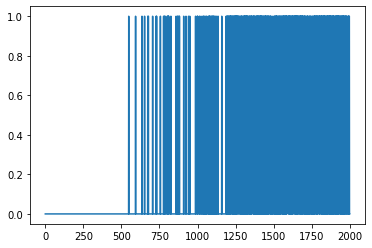

In [14]:
plt.plot(rList)

약 750번째 에피소드 정도에 다다랐을 때 네트워크가 지속적으로 목표에 도달하기 시작하는 것을 확인할 수 있음.  

다음은 에피소드별 단계 수를 담은 리스트를 시각화해보자.

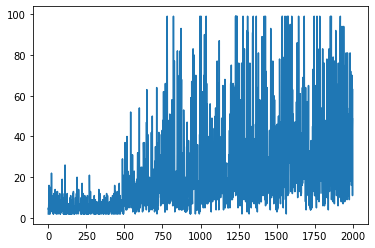

In [15]:
plt.plot(jList)

마찬가지로 750번째 에피소드 부근에서 단계 수가 늘어나는 것을 확인할 수 있음.